In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam

In [2]:
# data = np.genfromtxt('AAPL.csv', delimiter=',', skip_header=1, dtype=None, encoding='utf-8')
# print(data[:5])

In [3]:
raw = pd.read_csv('stocks_datasets/NDX.csv')
df = raw.iloc[2:].reset_index(drop = True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df = df.apply(pd.to_numeric, errors='coerce')
df['Returns'] = df['Close'].pct_change().fillna(method='ffill')
df.dropna()
df['MA_5'] = df['Close'].rolling(window = 5).mean()
df['MA_15'] = df['Close'].rolling(window = 15).mean()
df['Log_Price'] = pd.Series(np.log1p(df['Close']))
df['Log_Returns'] = pd.Series(np.log1p(df['Returns']))
df.dropna(inplace = True)

C:\Users\spenc\AppData\Local\Temp\ipykernel_27212\1572252574.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Returns'] = df['Close'].pct_change().fillna(method='ffill')


In [4]:
df.columns.values

array(['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'MA_5',
       'MA_15', 'Log_Price', 'Log_Returns'], dtype=object)

In [5]:
df = df[['High', 'Low', 'Open', 'Volume', 'Returns', 'MA_5',
       'MA_15', 'Log_Returns', 'Log_Price', 'Close']]


features_cols = ['High', 'Low', 'Open', 'Volume', 'MA_5',
       'MA_15']
target_col = 'Log_Price'

X = df[features_cols].values
y=df[target_col].values.reshape(-1, 1)

In [6]:
# Only use 'Close' for simplicity
data = df['Log_Price'].values.reshape(-1, 1)

# Scale prices between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [7]:
hidden_layer_size = 64

model = Sequential([
    LSTM(hidden_layer_size, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(hidden_layer_size),
    Dropout(0.2),
    Dense(1)
])

learning_rate = 0.001 
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

c:\Users\spenc\anaconda3\envs\ml_dl_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - loss: 0.0206 - mae: 0.0971 - val_loss: 0.0015 - val_mae: 0.0372
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0033 - mae: 0.0461 - val_loss: 0.0021 - val_mae: 0.0445
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0024 - mae: 0.0387 - val_loss: 0.0014 - val_mae: 0.0357
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0023 - mae: 0.0373 - val_loss: 1.4773e-04 - val_mae: 0.0100
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0023 - mae: 0.0368 - val_loss: 2.2666e-04 - val_mae: 0.0116
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0021 - mae: 0.0360 - val_loss: 4.7197e-04 - val_mae: 0.0193


In [9]:
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted.reshape(-1,1))
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


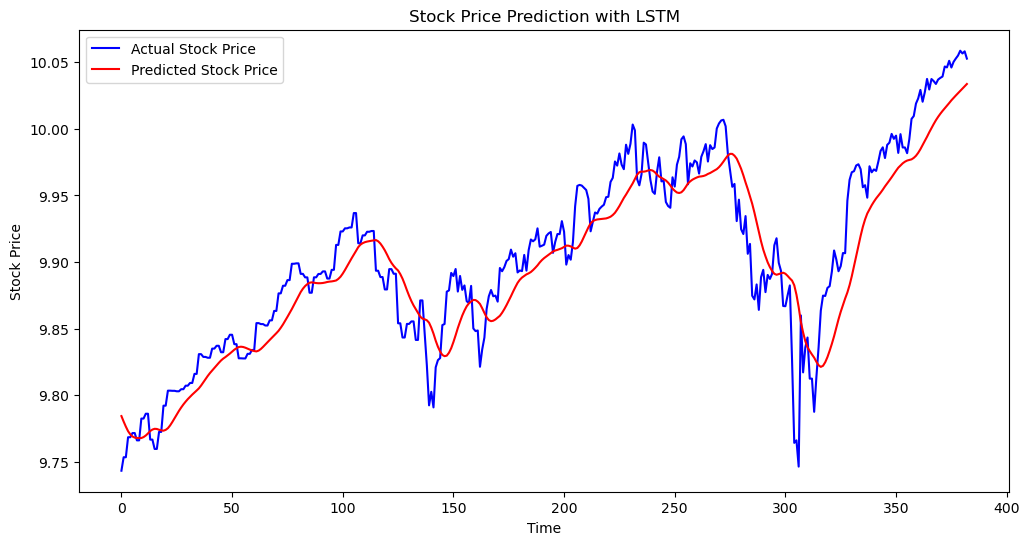

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(real_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('plots/stock_price_prediction.png')  # Save plot as PNG
plt.show()

In [11]:
import numpy as np
import pandas as pd

# If your predictions and actuals are in log scale:
real_prices_exp = np.exp(real_prices)         # convert actual log prices back
predicted_prices_exp = np.exp(predicted_prices)  # convert predicted log prices back

# Create comparison table
comparison_df = pd.DataFrame({
    'Actual Price': real_prices_exp.flatten(),
    'Predicted Price': predicted_prices_exp.flatten(),
    'Difference': real_prices_exp.flatten() - predicted_prices_exp.flatten()  # optional
})

# Show first 10 rows
print(comparison_df.tail(10))

# Save to CSV
comparison_df.to_csv('results/predicted_vs_actual_exp.csv', index=False)

     Actual Price  Predicted Price  Difference
373  23066.470703     22412.968750  653.501953
374  23181.060547     22457.236328  723.824219
375  23064.580078     22503.330078  561.250000
376  23163.410156     22544.789062  618.621094
377  23220.859375     22584.835938  636.023438
378  23273.250000     22624.394531  648.855469
379  23357.269531     22663.935547  693.333984
380  23309.300781     22705.017578  604.283203
381  23346.410156     22743.873047  602.537109
382  23219.119141     22780.927734  438.191406


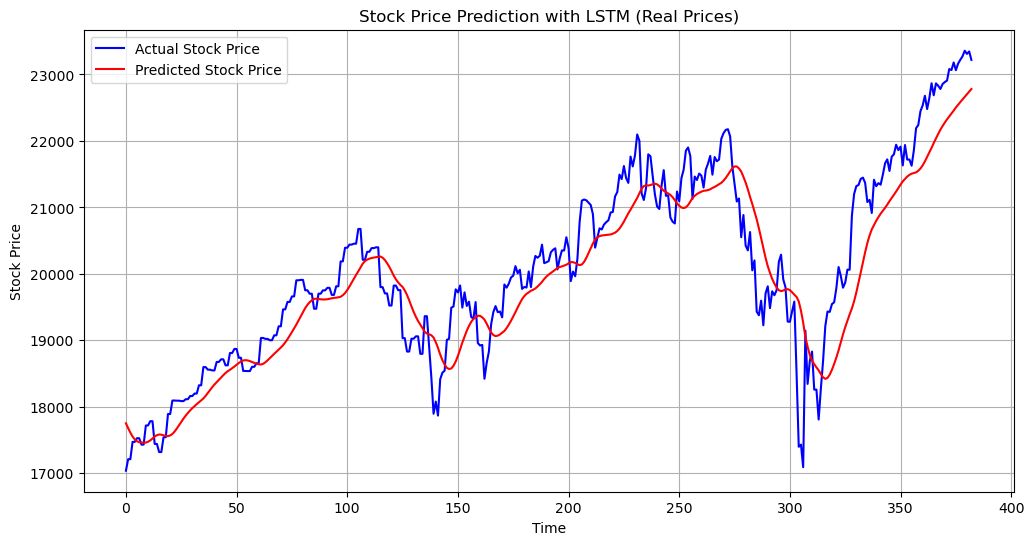

In [12]:
plt.figure(figsize=(12,6))
plt.plot(real_prices_exp, color='blue', label='Actual Stock Price')
plt.plot(predicted_prices_exp, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction with LSTM (Real Prices)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('plots/stock_price_prediction_real_price.png')
plt.show()


In [13]:
# Take the last 'seq_length' log prices from the scaled data
last_sequence = scaled_data[-seq_length:]         # shape (60, 1)
last_sequence = np.expand_dims(last_sequence, axis=0)  # shape (1, 60, 1)
last_sequence = last_sequence.astype(np.float32)

# Predict the next log price
next_log_scaled = model.predict(last_sequence)

# Invert the scaling
next_log_price = scaler.inverse_transform(next_log_scaled)

# Convert back to actual price
next_price = np.exp(next_log_price)
print("Next day predicted price:", next_price[0,0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Next day predicted price: 22810.605


In [14]:
df.index = pd.to_datetime(df.index)

# Last date in the index
last_date = df.index[-1]
print("Last date in data:", last_date)

# Next day (calendar day)
next_date = last_date + pd.Timedelta(days=1)
print("Next day for prediction:", next_date)


Last date in data: 2025-07-31 00:00:00
Next day for prediction: 2025-08-01 00:00:00


In [15]:
# Number of days to predict
n_days = 5


# Start with the last sequence from test data
last_sequence = X_test[-1]  # shape (seq_length, 1)
predictions = []

for _ in range(n_days):
    # Reshape to (1, seq_length, 1)
    input_seq = last_sequence.reshape(1, seq_length, 1)
    
    # Predict next log price
    next_log_price_scaled = model.predict(input_seq, verbose=0)
    
    # Append prediction to list
    predictions.append(next_log_price_scaled[0,0])
    
    # Update the sequence: drop first, append predicted
    last_sequence = np.append(last_sequence[1:], next_log_price_scaled[0,0])
    
# Convert back to original scale
predictions_scaled = np.array(predictions).reshape(-1,1)
predicted_log_prices = scaler.inverse_transform(predictions_scaled)

# If using log prices, exponentiate to get actual prices
predicted_prices = np.exp(predicted_log_prices)

# Generate next five dates
last_date = df.index[-1]
next_dates = pd.bdate_range(start=last_date, periods=n_days+1)[1:]

# Create a DataFrame
next_predictions = pd.DataFrame({
    'Date': next_dates,
    'Predicted_Price': predicted_prices.flatten()
})

print(next_predictions)


        Date  Predicted_Price
0 2025-08-01     22780.927734
1 2025-08-04     22794.533203
2 2025-08-05     22791.251953
3 2025-08-06     22776.062500
4 2025-08-07     22752.832031


In [16]:
next_predictions.head(100)

,Date,Predicted_Price
0,2025-08-01,22780.927734
1,2025-08-04,22794.533203
2,2025-08-05,22791.251953
3,2025-08-06,22776.062500
4,2025-08-07,22752.832031


In [17]:
import joblib
from tensorflow.keras.models import Sequential

# Save
model.save("lstm_model.keras")  # no .h5, uses SavedModel format
print("✅ LSTM model saved")

# 2️⃣ Save the scaler
# joblib.dump(scaler, "scaler.save")
# print("✅ Scaler saved to stocks_datasets/scaler.save")


✅ LSTM model saved
